In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os
from skimage import io
import mmcv
import xmltodict
import seaborn as sns
import json
from scipy.stats import hmean

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
AGGREGATED_DATA_PATH='../data/aggregated_labels/'
IMAGE_DATA_PATH='../data/complete_dataset/'
IOU_THRESHOLD = 0.7

In [4]:
def display_image_w_bbox(image_id, annotators = None, colors_annotators = ['blue','red','pink','brown','black','grey', 'white', 'yellow']):
    im = io.imread(os.path.join(IMAGE_DATA_PATH, f'{image_id}.jpg'))
    bboxes = get_image_info(image_id)

    if annotators is None:
        annotators = bboxes['annotator'].unique()
        
    fig, ax = plt.subplots(figsize=(20,30))
    ax.imshow(im)
    for bbox in bboxes[bboxes['annotator'].isin(annotators)].values:
        annotator = bbox[0]
        bbox = bbox[1:]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor=colors_annotators[annotator], facecolor='none')
        
        ax.add_patch(rect)
    plt.title(f'(w, h) = ()')
    fig.show()

In [5]:
def bbox_intersect(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    if x2 <= x1 or y2 <= y1 : return (0, 0, 0, 0) # None

    return (x1, y1, x2, y2)

def bbox_area(a)            : return (a[2] - a[0]) * (a[3] - a[1])

def bbox_IoU(a, b, return_area_a=False):
    inter = bbox_area(bbox_intersect(a, b))
    area_a = bbox_area(a)
    area_b = bbox_area(b)
    if area_a == 0 or area_b == 0:
        iou = 1
    else:
        iou = inter / (area_a + area_b - inter)
    if return_area_a:
        return iou, area_a
    else:
        return iou

In [6]:
    def get_masks_from_boxes(results_boxes, target_boxes):
        def add_mask(mask, boxes):
            for box in boxes:
                mask[box[1]:box[3], box[0]:box[2]] = 1
        all_boxes = np.concatenate([results_boxes, target_boxes])

        width, height = all_boxes.max(0)[[2,3]]

        pred_mask = np.zeros((height, width))
        target_mask = np.zeros((height, width))
        add_mask(pred_mask, results_boxes)
        add_mask(target_mask, target_boxes)

        return pred_mask, target_mask

    def get_metrics_from_masks(pred_mask, target_mask):
        tp = np.sum(pred_mask * target_mask)
        fp = np.sum(pred_mask * (1-target_mask))
        recall = tp/target_mask.sum()
        precision = tp/(tp+fp)
        f1_score = hmean([recall, precision])
        return recall, precision, f1_score

    def get_mask_metrics(results, target):
        pred_mask, target_mask = get_masks_from_boxes(results, target)
        return get_metrics_from_masks(pred_mask, target_mask)

In [7]:
def get_all_mask_metrics(image_ids):
    mask_metrics=[]
    for i, image_id in enumerate(image_ids):
        if not i % 10:
            print(f'left {len(image_ids) - i} images')
        bboxes = get_image_info(image_id)
        annotators = bboxes["annotator"].unique()
        for ann in annotators:
            bb_ann = bboxes[bboxes["annotator"] == ann][['xmin', 'ymin', 'xmax', 'ymax']]
            for ann2 in annotators:
                if ann2 < ann:
                    bb_ann2 = bboxes[bboxes["annotator"] == ann2][['xmin', 'ymin', 'xmax', 'ymax']]
                    recall, precision, f1 = get_mask_metrics(bb_ann.values, bb_ann2.values)
                    mask_metrics.append((image_id, ann, ann2, recall, precision, f1))
                    mask_metrics.append((image_id, ann2, ann, precision, recall, f1))
    return pd.DataFrame(mask_metrics, columns=['image_id', 'ann_pred', 'ann_gt', 'recall', 'precision', 'f1'])

In [8]:
def get_image_info(image_id, get_shape=False):
    with open(os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'), 'rb') as fd:
        xml_dict = xmltodict.parse(fd)
    shape = xml_dict["annotation"]["size"].values()
    bboxes = pd.DataFrame(
        [(r['name'], *r['bndbox'].values()) for r in xml_dict["annotation"]["object"]],
        columns=['annotator', 'xmin', 'ymin', 'xmax', 'ymax']).astype(np.int)
    if get_shape:
        return bboxes, shape
    return bboxes
def get_iou_annotator(image_ids):
    all_iou=[]
    for i, image_id in enumerate(image_ids):
        if not i % 10:
            print(f'left {len(image_ids) - i} images')
        bboxes = get_image_info(image_id)
        for ann in bboxes["annotator"].unique():
            bb_an = bboxes[bboxes["annotator"] == ann][['xmin', 'ymin', 'xmax', 'ymax']]
            mask_metrics.append((image_id, ann, bb_an, *get_mask_metrics(bb_an, bboxes)))
            for i, bbox in enumerate(bb_an.values):
                for _, bbox_2 in bboxes.iterrows():
                    all_iou.append((
                        image_id,
                        ann,
                        bbox_2['annotator'],
                        i,
                        *bbox_IoU(
                            bbox,
                            bbox_2[['xmin', 'ymin', 'xmax', 'ymax']],
                            return_area_a=True
                        )
                    ))
    return all_iou

In [9]:
image_ids = list(set([file.split('_')[0] for file in os.listdir(AGGREGATED_DATA_PATH) if file != 'classes.txt']))

In [10]:
if os.path.isfile('../data/cache_files/annotators_iou.json'):
    with open('../data/cache_files/annotators_iou.json', 'r') as fd:
        all_iou = json.load(fd)
else:
    all_iou = get_iou_annotator(image_ids)
    with open('../data/cache_files/annotators_iou.json', 'w') as fd:
        json_serializable_all_iou = [(str(iou[0]), int(iou[1]), int(iou[2]), int(iou[3]), float(iou[4]), int(iou[5])) for iou in all_iou]
        json.dump(json_serializable_all_iou, fd)
        del json_serializable_all_iou

In [11]:
d_iou = pd.DataFrame(all_iou, columns=["filename", "annotator_1", "annotator_2", "bbox_1_id", "iou", "area_1"])
d_iou = d_iou[d_iou['iou'] != 0]

In [12]:
image_ids[2]

'1597915750573'

In [13]:
d_iou.head()

,filename,annotator_1,annotator_2,bbox_1_id,iou,area_1
0,1597921124508,2,2,0,1.000000,13916
14,1597921124508,2,4,0,0.734654,13916
28,1597921124508,2,2,1,1.000000,5880
42,1597921124508,2,4,1,0.566445,5880
56,1597921124508,2,2,2,1.000000,20601


In [14]:
intersection_boxes = d_iou[
    ["filename", "annotator_1", "bbox_1_id"]
].drop_duplicates().groupby("filename")["annotator_1"].apply(lambda x: len(x.unique()))
all_intersected_filenames = intersection_boxes[intersection_boxes == 7].index

In [15]:
def add_mask(mask, boxes):
    for box in boxes:
        mask[box[1]:box[3], box[0]:box[2]] = 1
positive_prop_anns = [0]*8
positive_count_anns = [0]*8
for image_id in all_intersected_filenames.values:
    box_info, shape = get_image_info(image_id,get_shape=True)
    for ann in box_info["annotator"].unique():
        boxes = box_info[ann==box_info["annotator"]].drop("annotator",axis=1).values
        mask = np.zeros(tuple(map(int,shape))[:-1])
        add_mask(mask, boxes)
        positive_prop = mask.sum()/mask.size
        positive_prop_anns[ann] += positive_prop
        positive_count_anns[ann] += 1
total_pos_size_prop = np.array(positive_prop_anns) / np.array(positive_count_anns)
total_pos_size_prop

/home/usuaris/imatge/pau.marquez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


array([0.02505444, 0.00953642, 0.01843129,        nan, 0.02538169,
       0.02490145, 0.03216213, 0.03117065])

In [16]:
boxes = d_iou[["filename", "annotator_1", "bbox_1_id"]].drop_duplicates()
boxes_intersection = boxes[
    boxes.filename.isin(all_intersected_filenames)
]
mean_box_count = boxes_intersection.groupby(["filename", "annotator_1"]).size().to_frame().reset_index().groupby("annotator_1").mean().apply(lambda x: round(x,1))
boxes = d_iou[["filename", "annotator_1", "bbox_1_id", "area_1"]].drop_duplicates()
annotator_area = boxes[boxes.filename.isin(all_intersected_filenames)].groupby(
    ["filename", "annotator_1"]
)["area_1"].sum().groupby('annotator_1').mean().astype(int)

annotator_basic_stats = pd.concat([mean_box_count, annotator_area],axis=1).rename({"area_1": "Mean positive area per image", 0: "Mean number of boxes"}, axis = 1)
annotator_basic_stats["Mean area per box"] = (annotator_basic_stats.iloc[:,1]/ annotator_basic_stats.iloc[:,0]).astype(np.int)
annotator_basic_stats["Mean percentage of positive area per image"] = np.round(np.delete(total_pos_size_prop,3) * 100,2)
annotator_basic_stats = annotator_basic_stats.drop("Mean positive area per image", axis=1)
annotator_basic_stats

,Mean number of boxes,Mean area per box,Mean percentage of positive area per image
annotator_1,,,
0,18.1,17728,2.51
1,20.2,6023,0.95
2,18.3,13139,1.84
4,25.6,13353,2.54
5,19.9,16051,2.49
6,24.0,18093,3.22
7,24.1,17567,3.12


In [17]:
m_metrics = get_all_mask_metrics(image_ids)

left 52 images
left 42 images
left 32 images
left 22 images
left 12 images
left 2 images


In [18]:
mask_metrics = pd.pivot_table(
    m_metrics.groupby(['ann_pred','ann_gt'])[["f1", "recall"]].mean(),
    index=['ann_pred'],
    columns=["ann_gt"]
).rename({'recall': 'Mask Recall', 'f1': 'Mask F-score'}, axis=1)

In [19]:
mask_metrics[["Mask Recall"]].fillna(1).apply(lambda x: round(x,2))

Mask Recall                                    
ann_gt             0     1     2     4     5     6     7
ann_pred                                                
0               1.00  0.99  0.86  0.85  0.83  0.72  0.72
1               0.36  1.00  0.45  0.36  0.36  0.28  0.29
2               0.64  0.90  1.00  0.62  0.63  0.51  0.52
4               0.87  0.99  0.85  1.00  0.83  0.74  0.75
5               0.83  0.98  0.85  0.82  1.00  0.70  0.71
6               0.95  1.00  0.91  0.96  0.93  1.00  0.89
7               0.92  0.99  0.88  0.94  0.90  0.85  1.00

In [20]:
mask_metrics[["Mask F-score"]].fillna(1).apply(lambda x: round(x,2))

Mask F-score                                    
ann_gt              0     1     2     4     5     6     7
ann_pred                                                 
0                1.00  0.52  0.73  0.85  0.83  0.81  0.80
1                0.52  1.00  0.59  0.52  0.52  0.43  0.44
2                0.73  0.59  1.00  0.71  0.72  0.64  0.64
4                0.85  0.52  0.71  1.00  0.83  0.83  0.84
5                0.83  0.52  0.72  0.83  1.00  0.79  0.79
6                0.81  0.43  0.64  0.83  0.79  1.00  0.86
7                0.80  0.44  0.64  0.84  0.79  0.86  1.00

In [21]:
overlap_bbox = pd.pivot_table(
    d_iou.groupby(
        ['filename','annotator_1', 'annotator_2', 'bbox_1_id']
    )['iou'].apply(lambda x: int(any(x > 0.7))).groupby(
        ['annotator_1', 'annotator_2']
    ).mean().to_frame().reset_index().rename({
        'iou': 'Recall (iou threshold=0.7)',
        'annotator_1': 'annotator_gt',
        'annotator_2': 'annotator_pred',
    },axis=1),
    index=['annotator_pred'], columns=["annotator_gt"]
)
overlap_bbox.apply(lambda x: round(x,2))

Recall (iou threshold=0.7)                                    
annotator_gt                            0     1     2     4     5     6     7
annotator_pred                                                               
0                                    1.00  0.02  0.28  0.44  0.42  0.47  0.37
1                                    0.06  1.00  0.10  0.06  0.06  0.05  0.06
2                                    0.30  0.04  1.00  0.21  0.23  0.18  0.15
4                                    0.54  0.02  0.25  1.00  0.38  0.46  0.46
5                                    0.48  0.01  0.25  0.35  1.00  0.40  0.34
6                                    0.49  0.00  0.18  0.40  0.38  1.00  0.48
7                                    0.40  0.01  0.17  0.40  0.33  0.48  1.00

In [22]:
f1_matrix = overlap_bbox.copy()
for i in range(overlap_bbox.shape[0]):
    for j in range(overlap_bbox.shape[1]):
        f1_matrix.values[i][j] = hmean([overlap_bbox.values[i][j], overlap_bbox.values[j][i]])
f1_matrix = f1_matrix.rename({'Recall (iou threshold=0.7)': f'F1-score (threshold={IOU_THRESHOLD})'},axis=1)

In [23]:
f1_matrix.apply(lambda x: round(x,2))

F1-score (threshold=0.7)                                    
annotator_gt                          0     1     2     4     5     6     7
annotator_pred                                                             
0                                  1.00  0.03  0.29  0.48  0.45  0.48  0.38
1                                  0.03  1.00  0.06  0.02  0.02  0.01  0.01
2                                  0.29  0.06  1.00  0.23  0.24  0.18  0.16
4                                  0.48  0.02  0.23  1.00  0.36  0.43  0.43
5                                  0.45  0.02  0.24  0.36  1.00  0.39  0.34
6                                  0.48  0.01  0.18  0.43  0.39  1.00  0.48
7                                  0.38  0.01  0.16  0.43  0.34  0.48  1.00

In [24]:
annotators_mapped_iou = d_iou.copy()
annotators = [0,4,5,6]
annotators_mapped_iou = annotators_mapped_iou[
    annotators_mapped_iou['annotator_1'].isin(annotators) & annotators_mapped_iou['annotator_2'].isin(annotators) 
    & (annotators_mapped_iou['annotator_1'] != annotators_mapped_iou['annotator_2'])
]
copy = annotators_mapped_iou.copy()
annotators_mapped_iou["annotator_2"] = ','.join(map(str,annotators))
copy["annotator_1"] = ','.join(map(str,annotators))
annotators_mapped_iou = pd.concat([
    annotators_mapped_iou,
    copy
])
overlap_bbox_ann = pd.pivot_table(
    annotators_mapped_iou.groupby(
        ['filename','annotator_1', 'annotator_2', 'bbox_1_id']
    )['iou'].apply(lambda x: int(any(x > 0.7))).groupby(
        ['annotator_1', 'annotator_2']
    ).mean().to_frame().reset_index().rename({
        'iou': 'Precision(iou threshold=0.7)',
        'annotator_1': 'annotator_gt',
        'annotator_2': 'annotator_pred',
    },axis=1),
    index=['annotator_gt'], columns=["annotator_pred"]
)

Bounding box metrics (not mask metrics) for the set of annotators {0,4,5,6}: For each annotator, compare with the rest of annotations.

In [25]:
precision = overlap_bbox_ann.iloc[:-1,-1]
recall = overlap_bbox_ann.iloc[-1,:-1]

f1_score = [hmean([p, r]) for p, r in zip(precision.values, recall.values)]
pd.DataFrame({"precision": precision.values, "recall": recall.values, "f1": f1_score}, index = precision.index)

,precision,recall,f1
annotator_gt,,,
0,0.738306,0.676523,0.706066
4,0.560953,0.724806,0.632439
5,0.577982,0.620311,0.598399
6,0.632951,0.667254,0.649650


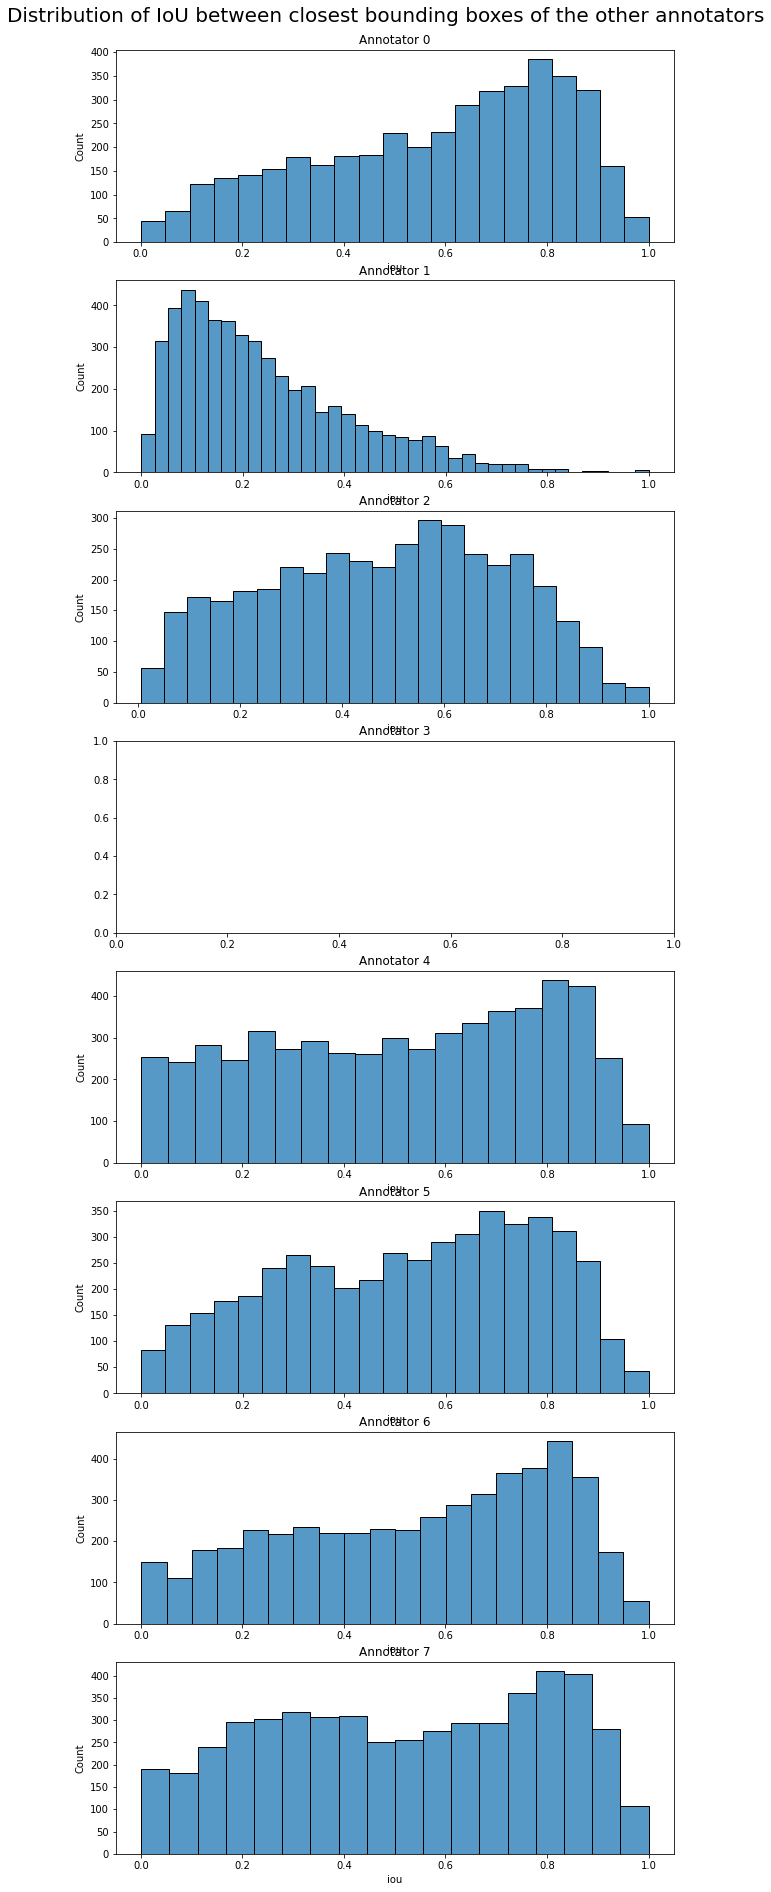

In [26]:
fig, ax = plt.subplots(8, figsize=(10,30))
plt.suptitle('Distribution of IoU between closest bounding boxes of the other annotators',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    d = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 != ann)].groupby(['filename','bbox_1_id', 'annotator_2']).max()
    sns.histplot(d[(d.annotator_1 == ann)].iou, ax=ax[ann])
fig.subplots_adjust(top=0.96)
plt.show()

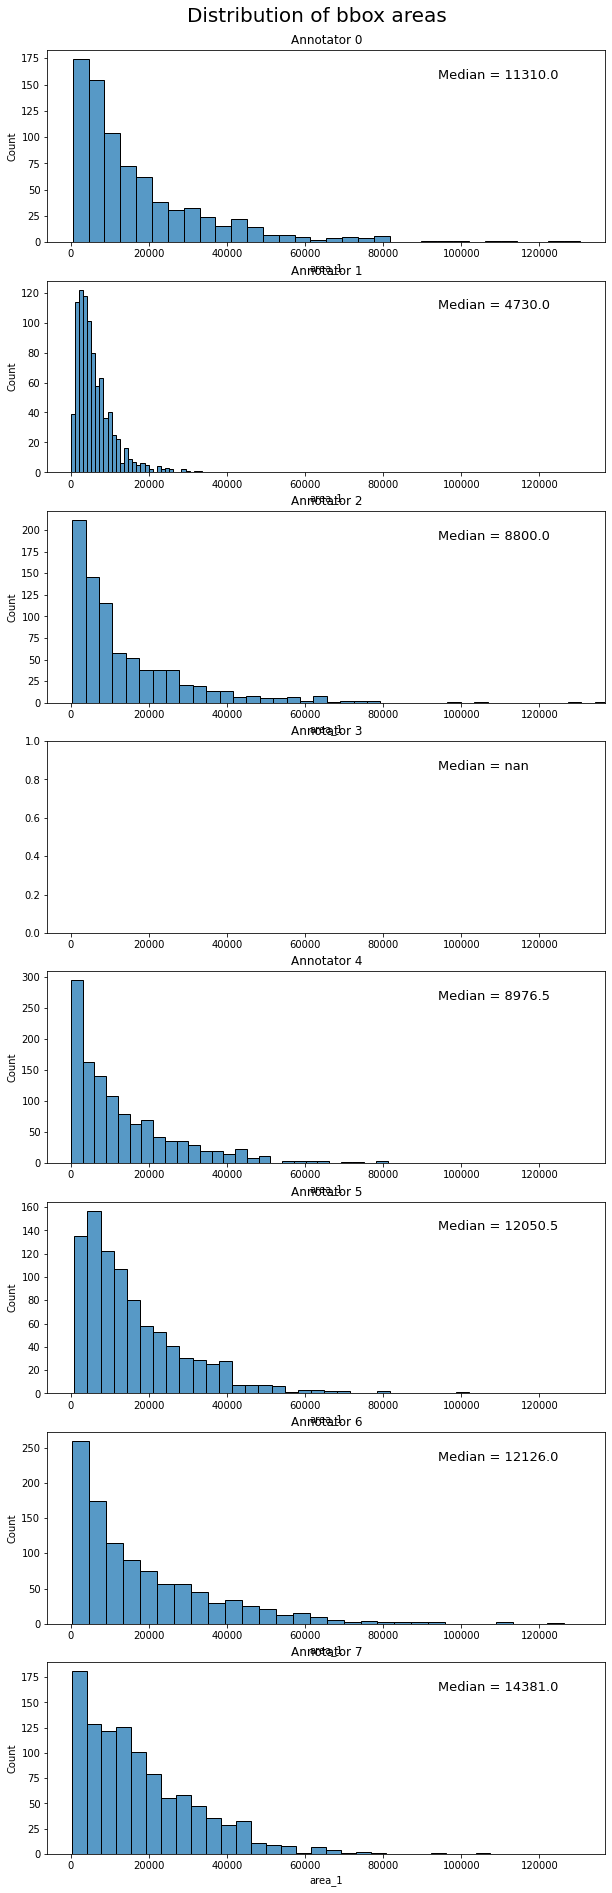

In [27]:
fig, ax = plt.subplots(8, figsize=(10,30))
plt.suptitle('Distribution of bbox areas',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    areas_bbox = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 != ann)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
    sns.histplot(areas_bbox, ax=ax[ann])
    ax[ann].annotate(f"Median = {round(areas_bbox.median(),2)}", xy=(0.6,0.85), xytext=(0.7, 0.85), textcoords='axes fraction',fontsize=13)
for ax_i in ax:
    ax_i.sharex(ax[0])
fig.subplots_adjust(top=0.96)
plt.show()

Some annotators overlap bounding boxes within the same image. In general, this is an issue when training the object detection model.

Annotator 7 has much more overlap.

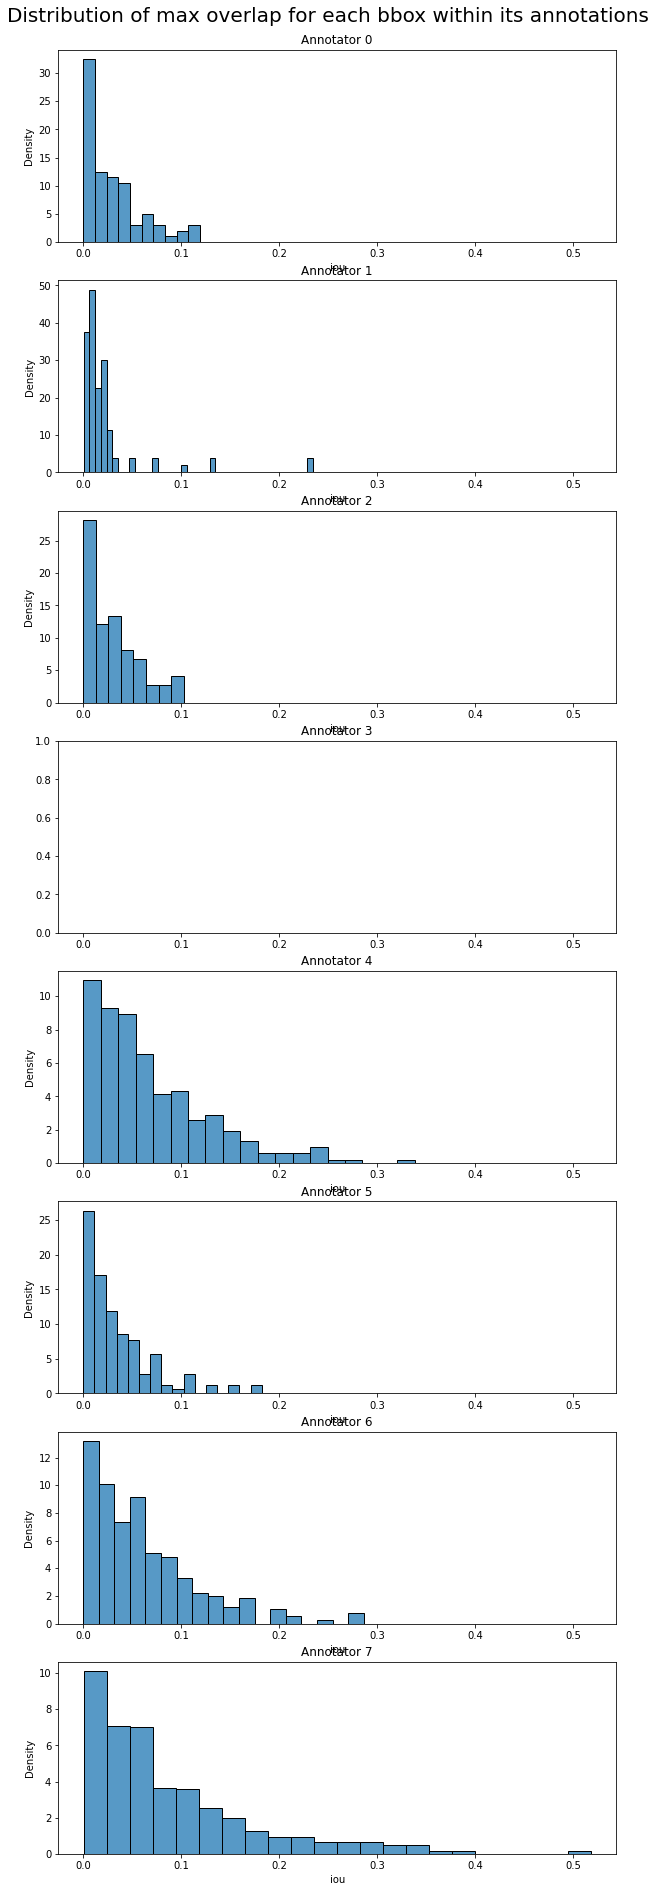

In [28]:
fig, ax = plt.subplots(8, figsize=(10,30))
plt.suptitle('Distribution of max overlap for each bbox within its annotations',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    overlap_bbox = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 == ann) & (d_iou.iou < 0.95) & (d_iou.iou > -0.01)].groupby(['filename','bbox_1_id', 'annotator_1'])['iou'].max()
    sns.histplot(overlap_bbox, ax=ax[ann], stat='density')
for ax_i in ax:
    ax_i.sharex(ax[-1])
fig.subplots_adjust(top=0.96)
plt.show()

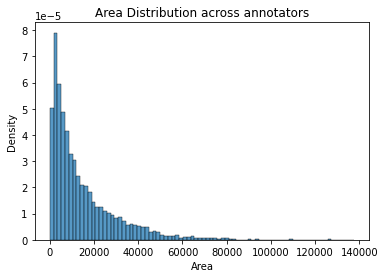

In [29]:
areas_bbox = d_iou[(d_iou.annotator_1 == d_iou.annotator_2)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
sns.histplot(areas_bbox, stat='density', bins=80)
plt.title('Area Distribution across annotators')
plt.xlabel('Area')
plt.show()

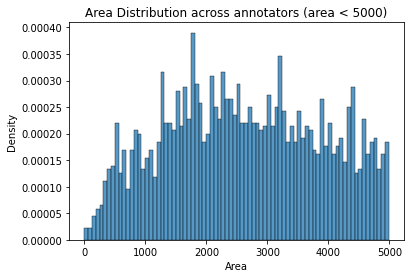

In [30]:
areas_bbox = d_iou[(d_iou.annotator_1 == d_iou.annotator_2)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
sns.histplot(areas_bbox[areas_bbox < 5000], stat='density', bins=80)
plt.title('Area Distribution across annotators (area < 5000)')
plt.xlabel('Area')
plt.show()

In [31]:
colors_annotators = ['blue','red','pink','brown','purple','grey', 'white', 'yellow']

In [32]:
list(enumerate(colors_annotators))

[(0, 'blue'),
 (1, 'red'),
 (2, 'pink'),
 (3, 'brown'),
 (4, 'purple'),
 (5, 'grey'),
 (6, 'white'),
 (7, 'yellow')]

Some pictures with its annotations and the annotator's corresponding color.

In [ ]:
for image_id in image_ids[1:2]:
    print(image_id)
    display_image_w_bbox(image_id,colors_annotators=colors_annotators)

In [ ]:
for image_id in image_ids[:2]:
    display_image_w_bbox(image_id, annotators=[0,2,7])